In [1]:
from ioMicro import *

In [34]:
import ioMicro
print(ioMicro.__file__)

C:\Users\Scope2\Scope2Scripts\Zane_Ying_Virus\ioMicro.py


### Map data

In [307]:
data_folder= r'S:\ZaneTrit_3_3_2023'

# map all the hybes
hybes =  glob.glob(data_folder+os.sep+'H*')
# map all the fovs
fovs = [os.path.basename(fl)for fl in glob.glob(hybes[0]+os.sep+'*.zarr')]
def get_Hi(fld): 
    try: return int(os.path.basename(fld)[1:]) 
    except: return -1
    
hybes = np.array(hybes)[np.argsort([get_Hi(hybe) for hybe in hybes ])]

In [308]:
def drift_correction(hybes,fov,save_file,iiref=None,redo=False,ssz=20):
    if iiref is None: iiref = len(hybes)//2
    dic_drift = {}
    if os.path.exists(save_file):
        dic_drift = pickle.load(open(save_file,'rb'))
    tags = [os.path.basename(hybe) for hybe in hybes]
    redo = ~np.all([tag in dic_drift for tag in tags])
    if redo:
        #Load the reference dapi image
        fl1 = hybes[iiref]+os.sep+fov
        im1 = read_im(fl1)
        ncols,sz,sx,sy = im1.shape
        im1dapi = np.array(im1[-1][(sz-ssz)//2:(sz+ssz)//2],dtype=np.float32)
        ###Perform drift

        for hybe in tqdm(hybes):
            fl2 = hybe+os.sep+fov
            tag = os.path.basename(hybe)
            if not (tag in dic_drift):
                im2 = read_im(fl2)
                ncols,sz,sx,sy = im1.shape
                

                im2dapi = np.array(im2[-1][(sz-ssz)//2:(sz+ssz)//2],dtype=np.float32)
                txyz,txyzs = get_txyz(im1dapi,im2dapi,sz_norm=30,sz = 500,nelems=5)
                dic_drift[tag]=[txyz,txyzs]
                #print(txyz,txyzs)
                pickle.dump(dic_drift,open(save_file,'wb'))

In [7]:
from scipy.signal import fftconvolve
def fit(hybe,fov,analysis_folder=r'S:\ZaneTrit_3_3_2023_analysis',icol=0,redo=False,hth = 50,plt_val=True):
    fl = hybe+os.sep+fov
    tag = os.path.basename(hybe)
    save_file=analysis_folder+os.sep+fov.split('.')[0]+'--'+tag+'_fits_icol'+str(icol)+'.npz'
    if not os.path.exists(save_file) or redo:
        im = read_im(fl)
        ncols,sz,sx,sy = im.shape
        #for icol in np.arange(ncols-1):
        imS = np.array(im[icol],dtype=np.float32) #GFP cy5 half
        #Convolve with gaussian 
        sz=5
        X = np.indices([2*sz+1]*3)-sz
        sigma=1.5
        gaussian = np.exp(-np.sum(X**2,axis=0)/2/sigma**2)
        im_conv = fftconvolve(imS,gaussian,mode='same')/np.sum(gaussian)
        #Subtract local background
        im_conv_ = norm_slice(im_conv,s=30)
        #fit the spots
        Xh = get_local_max(im_conv_,hth,im_raw=im_conv,delta=1,delta_fit=3)
        if plt_val:
            import napari
            v = napari.view_image(im_conv_)
            v.add_image(imS)
            h = Xh[:,-1]
            size = 5+np.clip(h/np.percentile(h,99.9),0,1)*10
            v.add_points(Xh[:,:3],size=size,face_color=[0,0,0,0],edge_color='y')
        np.savez_compressed(save_file,Xh=Xh)

In [87]:
for hybe in tqdm(hybes):
    for icol in range(2):
        fit(hybe, fovs[30],icol=icol,analysis_folder=r'S:\ZaneTrit_3_3_2023_analysis',redo=False,hth = 50,plt_val=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [31:24<00:00, 99.17s/it]


In [9]:

fit(hybes[4], fovs[30],icol=1,analysis_folder=r'S:\ZaneTrit_3_3_2023_analysis',redo=True,hth = 50,plt_val=True)


C:\Users\Scope2\anaconda3\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [382]:
def tag_to_hybe(tag):
    try:
        return int(tag[1:])
    except:
        return -1
class decoder_simple():
    def __init__(self,save_folder=r'S:\ZaneTrit_3_3_2023_analysis',fov='Conv_zscan__30',ncols=2,
                 hybe_bit_dic={(1, 1): 0, (1, 0): 1, (2, 0): 2, (2, 1): 3, (3, 1): 4, (3, 0): 5, (4, 1): 6, (4, 0): 7, (5, 0): 8, (5, 1): 9, (6, 1): 10, (6, 0): 11, (7, 1): 12, (7, 0): 13, (8, 0): 14, (8, 1): 15, (9, 1): 16, (9, 0): 17, (10, 1): 18, (10, 0): 19, (11, 0): 20, (11, 1): 21, (12, 1): 22, (12, 0): 23, (13, 1): 24, (13, 0): 25, (14, 1): 26, (14, 0): 27, (15, 1): 28, (15, 0): 29, (16, 1): 30, (16, 0): 31, (17, 1): 32, (17, 0): 33, (18, 1): 34, (18, 0): 35},
                chromatic_fl = 'chromatic_abberation_matrix_Scope2DC60xobj.npy'):
        self.save_folder = save_folder
        self.fov = fov
        self.decoded_fl = save_folder+os.sep+'decoded_'+fov.split('.')[0]+'.npz'
        self.drift_fl = save_folder+os.sep+fov.split('.')[0]+'_drift.pkl'
        self.ncols=ncols
        self.hybe_bit_dic=hybe_bit_dic
        self.chromatic_fl = self.save_folder+os.sep+chromatic_fl
    def get_XH(self,excl=20,Xmax=2000):
        """Load in the fitted dots for each field of view.
        Apply chromatic abberation correction and drift correction and append corrected fitted data 
        int self.XH structure"""
        ncols = self.ncols
        drift_dic = pickle.load(open(self.drift_fl,'rb'))
        tags = list(drift_dic.keys())
        if not os.path.exists(self.chromatic_fl):
            self.m=None
        else:
            self.m = np.load(self.chromatic_fl)
        XH = []
        save_folder = self.save_folder
        fov = self.fov
        for tag in tqdm(tags):
            iH = tag_to_hybe(tag)
            for icol in range(ncols):
                #tag = os.path.basename(fld)#Conv_zscan__30--H_GFP_fits_icol0
                save_fl = save_folder+os.sep+fov.split('.')[0]+'--'+tag+'_fits_icol'+str(icol)+'.npz'
                Xh = np.load(save_fl)['Xh']
                X2d = Xh[:,1:3]
                kp = np.all((X2d>excl)&(X2d<(Xmax-excl)),axis=-1)
                Xh = Xh[kp]
                tzxy = drift_dic[tag][0]
                m=None
                if icol==0: m=self.m
                
                Xh[:,:3] = apply_colorcor(Xh[:,:3],m=m)
                Xh[:,:3]-=tzxy# drift correction
                #chromatic abberation -to check
                bit = self.hybe_bit_dic.get((iH,icol),-1)
                icolR = np.array([[icol,bit]]*len(Xh))
                XH_ = np.concatenate([Xh,icolR],axis=-1)
                XH.extend(XH_)
        self.XH = np.array(XH)
    def load_library(self,lib_fl = r'codebook_0_New_DCBB-300_MERFISH_encoding_2_21_2023.csv',nblanks=-1):
        code_txt = np.array([ln.replace('\n','').split(',') for ln in open(lib_fl,'r') if ',' in ln])
        gns = code_txt[1:,0]
        code_01 = code_txt[1:,2:].astype(int)
        codes = np.array([np.where(cd)[0] for cd in code_01])
        codes_ = [list(np.sort(cd)) for cd in codes]
        nbits = np.max(codes)+1

        codes__ = codes_
        gns__ = list(gns)
        
        self.lib_fl = lib_fl ### name of coding library
        self.nbits = nbits ### number of bits
        self.codes_01 = code_01
        
        
        
        if nblanks>=0:
            ### get extrablanks
            from scipy.spatial.distance import pdist,cdist
            M = self.codes_01
            non = np.sum(M,axis=1)[0]
            ntotal = M.shape[-1]
            random_codes = np.array([get_random_binary(non=non,ntotal=ntotal) for it in range(len(M))])
            dM = cdist(random_codes,M,metric='hamming')*M.shape[-1]
            minD = np.min(dM,axis=-1)
            blank_barcodes = random_codes[minD>0]
            
            
            dists_bits = pdist(blank_barcodes,metric='hamming')*blank_barcodes.shape[-1]
            nbits,cts = np.unique(dists_bits,return_counts=True)
            plt.figure()
            plt.plot(nbits,cts,'o-',label='blanks')

            dists_bits = pdist(M,metric='hamming')*M.shape[-1]
            nbits,cts = np.unique(dists_bits,return_counts=True)
            plt.plot(nbits,cts,'o-',label='real_codes')
            plt.xlabel('Hamming distance')
            plt.ylabel('Number of pairs of codes')
            codes__ = codes_ + list(np.array([np.where(cd)[0] for cd in blank_barcodes]))
            gns__ = list(gns)+ ['blanke'+str(ign+1).zfill(6) for ign in range(len(blank_barcodes))]
        
        bad_gns = np.array(['blank' in e for e in gns__])
        good_gns = np.where(~bad_gns)[0]
        bad_gns = np.where(bad_gns)[0]
        if nblanks>=0:
            self.codes_01 = np.concatenate([code_01,blank_barcodes],axis=0) ### final extended codes of form [0,1,0,0,1...]
        self.gns_names = gns__  ### names of genes and blank codes
        self.bad_gns = bad_gns ### indices of the blank codes
        self.good_gns = good_gns ### indices of the good gene codes
        self.codes__ = codes__ ### final extended codes of form [bit1,bit2,bit3,bit4]
    def get_inters(self,dinstance_th=2,enforce_color=False):
        """Get an initial intersection of points and save in self.res"""
        res =[]
        if enforce_color:
            icols = self.XH[:,-2]
            XH = self.XH
            for icol in tqdm(np.unique(icols)):
                inds = np.where(icols==icol)[0]
                Xs = XH[inds,:3]
                Ts = cKDTree(Xs)
                res_ = Ts.query_ball_tree(Ts,dinstance_th)
                res += [inds[r] for r in res_]
        else:
            XH = self.XH
            Xs = XH[:,:3]
            Ts = cKDTree(Xs)
            res = Ts.query_ball_tree(Ts,dinstance_th)
        self.res = res
    def get_icodes(self,nmin_bits=8,method = 'top',redo=False,norm_brightness=-1,enforce_unique=False):    
        #### unfold res which is a list of list with clusters of loc.

        res = self.res

        import time
        start = time.time()
        res = [r for r in res if len(r)>=nmin_bits]
        print(len(res))
        #rlens = [len(r) for r in res]
        #edges = np.cumsum([0]+rlens)
        res_unfolder = np.array([r_ for r in res for r_ in r])
        #res0 = np.array([r[0] for r in res for r_ in r])
        ires = np.array([ir for ir,r in enumerate(res) for r_ in r])
        print("Unfolded molecules:",time.time()-start)

        ### get scores across bits
        import time
        start = time.time()
        RS = self.XH[:,-1].astype(int)
        brighness = self.XH[:,-3]
        brighness_n = brighness.copy()
        if norm_brightness is not None:
            colors = self.XH[:,norm_brightness]#self.XH[:,-1] for bits
            med_cols = {col: np.median(brighness[col==colors])for col in np.unique(colors)}
            for col in np.unique(colors):
                brighness_n[col==colors]=brighness[col==colors]/med_cols[col]
        scores = brighness_n[res_unfolder]

        bits_unfold = RS[res_unfolder]
        nbits = len(np.unique(RS))
        scores_bits = np.zeros([len(res),nbits])
        arg_scores = np.argsort(scores)
        scores_bits[ires[arg_scores],bits_unfold[arg_scores]]=scores[arg_scores]
        self.scores_bits = scores_bits #for each bit gives the normalized brightbess per bit


        ### get the dictoionary with the reduced codes assumind dropoff and only nkeep onbits
        nkeep=nmin_bits
        import itertools
        dec_dic = {}
        for ic,cd in enumerate(M):
            inds = np.where(cd)[0]

            keys = list(itertools.combinations(inds,nkeep))
            for key in keys:
                if key not in dec_dic:dec_dic[key]=[]
                dec_dic[key] += [ic]
        self.dec_dic = dec_dic


        import time
        start = time.time()
        ### There are multiple avenues here: 
        #### nearest neighbors - slowest
        #### find top nmin_bits bits and call that a code - simplest and fastest


        if method == 'top':
            codes = self.codes__## changed
            vals = np.argsort(scores_bits[:,:],axis=-1)
            bcodes = np.sort(vals[:,-nmin_bits:],axis=-1)
            dec_dic = self.dec_dic
            icodesN = np.array([np.random.choice(dec_dic.get(tuple(cd),[-1])) for cd in bcodes])

            self.icodesN_interm=icodesN
            igood = np.where(icodesN>-1)[0]
            inds_spotsN =  np.zeros([len(res),nbits],dtype=int)-1
            inds_spotsN[ires[arg_scores],bits_unfold[arg_scores]]=res_unfolder[arg_scores]
            res_prunedN = np.array([inds_spotsN[imol][codes[icd]] for imol,icd in enumerate(icodesN) if icd>-1])
            scores_prunedN = np.array([scores_bits[imol][codes[icd]] for imol,icd in enumerate(icodesN) if icd>-1])
            icodesN = icodesN[igood]

        is_good = np.sum(np.array(res_prunedN)>-1,axis=-1)>=nmin_bits
        res_prunedN = res_prunedN[is_good]
        scores_prunedN = scores_prunedN[is_good]
        icodesN = icodesN[is_good]
        print("Computed the decoding:",time.time()-start)


        self.scores_prunedN = scores_prunedN
        self.res_prunedN = res_prunedN
        self.icodesN = icodesN
        self.XH_pruned = self.XH[self.res_prunedN]




        if enforce_unique:
            import time
            start = time.time()

            mean_scores = np.mean(scores_prunedN,axis=-1)
            ordered_mols = np.argsort(mean_scores)[::-1]
            keep_mols = []
            visited = np.zeros(len(self.XH))
            for imol in tqdm(ordered_mols):
                r = np.array(res_prunedN[imol])
                r_ = r[r>=0]
                if np.all(visited[r_]==0):
                    keep_mols.append(imol)
                    visited[r_]=1
            keep_mols = np.array(keep_mols)
            self.scores_prunedN = scores_prunedN[keep_mols]
            self.res_prunedN = res_prunedN[keep_mols]
            self.icodesN = icodesN[keep_mols]
            print("Computed best unique assigment:",time.time()-start)



            self.XH_pruned = self.XH[self.res_prunedN]

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  9.02it/s]


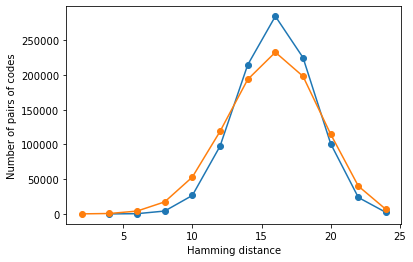

In [400]:

dec = decoder_simple()
dec.get_XH()
dec.load_library(lib_fl = r'C:\Users\Scope2\Scope2Scripts\Zane_Ying_Virus\codebook.csv',nblanks=1)
dec.codes_01.shape
keep = dec.XH[:,-1]>=0#keep only MERFISH
dec.XH_GFP = dec.XH[~keep]#GFP
dec.XH = dec.XH[keep]

In [401]:
dec.get_inters(dinstance_th=3.5)

### Which codes are decoded?

379623
Unfolded molecules: 0.6715595722198486
Computed the decoding: 3.2227296829223633


100%|████████████████████████████████████████████████████████████████████████| 11783/11783 [00:00<00:00, 145346.62it/s]

Computed best unique assigment: 0.08507180213928223


Text(0, 0.5, 'Number of decoded codes')

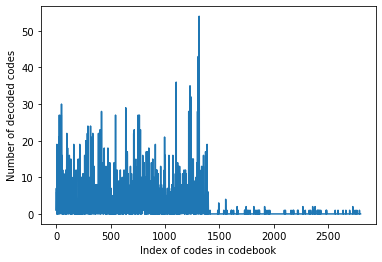

In [472]:
get_icodes(dec,nmin_bits=7,method = 'top',redo=True,norm_brightness=-2,enforce_unique=True)
cts,icds = np.histogram(dec.icodesN,bins=np.arange(len(dec.codes_01)+1))
plt.plot(icds[:-1],cts)
plt.xlabel('Index of codes in codebook')
plt.ylabel("Number of decoded codes")

Text(0, 0.5, 'Number of CRE transcripts')

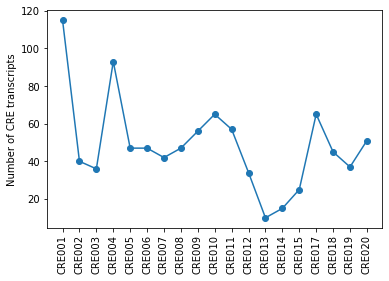

In [471]:
import pandas as pd
cre_names = np.array(list(pd.read_csv('codebook.csv')['id']))
nms,cts = np.unique(cre_names[dec.icodesN[dec.icodesN<len(cre_names)]],return_counts=True)
plt.figure()
plt.plot(cts,'o-')
plt.xticks(np.arange(len(nms)),nms,rotation='vertical');
plt.ylabel('Number of CRE transcripts')

Text(0, 0.5, 'Number of CRE transcripts')

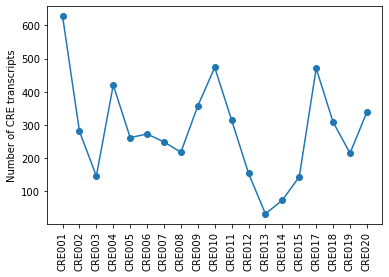

In [473]:
import pandas as pd
cre_names = np.array(list(pd.read_csv('codebook.csv')['id']))
nms,cts = np.unique(cre_names[dec.icodesN[dec.icodesN<len(cre_names)]],return_counts=True)
plt.figure()
plt.plot(cts,'o-')
plt.xticks(np.arange(len(nms)),nms,rotation='vertical');
plt.ylabel('Number of CRE transcripts')

### Plot the decoded barcodes

In [453]:
### example on how to visualize the points
nkeep =np.min(np.sum(dec.res_prunedN>-1,-1))
ikeep = np.sort(dec.res_prunedN,axis=-1)[:,::-1][:,:nkeep]
dec.XH_pruned = dec.XH[ikeep]

XH_dec = np.mean(dec.XH_pruned[:,:,:],axis=1)
H = XH_dec[:,-3]
size = 4+np.clip(H/np.percentile(H,99),0,1)*10
import napari
viewer = napari.view_points(XH_dec[:,:3],size=size)

C:\Users\Scope2\anaconda3\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


### Plot the 2 color GFP

In [454]:
col = dec.XH_GFP[:,-2]
dec.XH_GFP_1 = dec.XH_GFP[col==0,:]
dec.XH_GFP_2 = dec.XH_GFP[col==1,:]
import napari
h = dec.XH_GFP_1[:,-3]
size = np.clip(h/np.percentile(h,95),0,1)*5
viewer.add_points(dec.XH_GFP_1[:,:3],face_color='r',blending='additive',size=size)
h = dec.XH_GFP_2[:,-3]
size = np.clip(h/np.percentile(h,95),0,1)*5
viewer.add_points(dec.XH_GFP_2[:,:3],face_color='g',blending='additive',size=size)

<Points layer 'Points [2]' at 0x1ebca38c4f0>

C:\Users\Scope2\anaconda3\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 1003.3205575917281, 1006.2708082341934), zoom=0.25971940702513735, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((2.9385482748974017, 74.54450246528452, 1.0), (26.6896507783219, 1980.9514644051342, 1.0), (44.64794438383235, 1968.8936720845543, 1.0)), current_step=(35, 976, 961), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Points layer 'X' at 0x1ec4233beb0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), over

In [377]:
X = dec.XH[:,1:3]
keep =  dec.XH[:,-1]==0
viewer = napari.view_points(X[keep],size=10)
keep =  dec.XH[:,-1]==10
viewer.add_points(X[keep],size=10,face_color='r')

C:\Users\Scope2\anaconda3\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Points layer 'Points [1]' at 0x1ebda0a7b20>

In [370]:
dec.get_inters(dinstance_th=2)

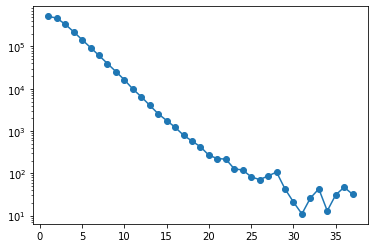

In [332]:
nes,cts = np.unique([len(c) for c in dec.res],return_counts=True)
plt.semilogy(nes,cts,'o-')

In [333]:
nkeep=8
M = dec.codes_01
import itertools
dec_dic = {}
for ic,cd in enumerate(M):
    inds = np.where(cd)[0]
    
    keys = list(itertools.combinations(inds,nkeep))
    for key in keys:
        if key not in dec_dic:dec_dic[key]=[]
        dec_dic[key] += [ic]

In [334]:
np.mean([len(dec_dic[key]) for key in dec_dic])

1.0832085481254083

In [336]:
#[len(dec_dic[key]) for key in dec_dic]

110743
Unfolded molecules: 0.2912461757659912
Computed the decoding: 0.9638161659240723


100%|██████████████████████████████████████████████████████████████████████████| 2310/2310 [00:00<00:00, 109908.14it/s]

Computed best unique assigment: 0.02301931381225586


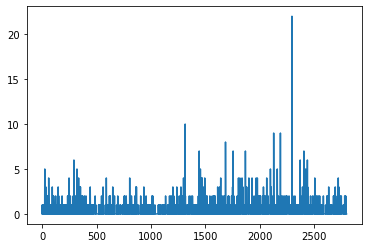

In [366]:
### example on how to visualize the points
dec.XH_pruned = dec.XH[np.sort(dec.res_prunedN,axis=-1)[:,::-1]]
X = dec.XH_pruned[:,0,:3]
import napari
napari.view_points(X)

C:\Users\Scope2\anaconda3\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 993.36140200474, 1001.7416086976258), zoom=0.602919242504572, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((2.9385482748974017, 74.57037978811738, 1.0), (26.6896507783219, 1961.033153231158, 1.0), (44.89029376942064, 1959.592923625831, 1.0)), current_step=(35, 966, 957), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Points layer 'X' at 0x1eb46cbac10>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Ov

In [249]:
np.mean(np.array([np.sum(cd>-1)for cd in dec.res_prunedN])>=7)

1.0

In [248]:
np.array([np.sum(cd>-1)for cd in dec.res_prunedN])

array([7, 7, 8, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       9, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 8, 7, 7, 9, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7,
       7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 9, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 8, 8, 8, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 8, 7, 7, 7, 7, 8, 8, 7, 7, 7,
       7, 7, 7, 7, 8, 7, 7, 8, 8, 8, 7, 8, 8, 8, 7, 8, 8, 8, 8, 7, 7, 7,
       7, 8, 9, 7, 7, 7, 8, 7, 8, 7, 7, 8, 8, 7, 8, 7, 8, 8, 7, 7, 8, 8,
       7, 7, 8, 7, 7, 7, 7, 8, 7, 7, 8, 7, 8, 7, 7, 7, 7, 7, 7, 8, 8, 7,
       7, 7, 7, 7, 7, 8, 7, 8, 8, 7, 8, 8, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7,
       7, 7, 7, 7, 8, 7, 7, 7, 8, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8, 8, 7,
       8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 8, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [213]:
np.sum(dec.icodesN_interm>-1)

7416

In [217]:
dec.XH_pruned.shape

(5929, 12, 10)

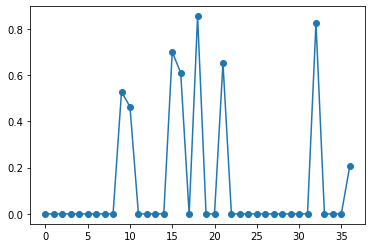

In [135]:
plt.plot(dec.scores_bits[0],'o-')

In [128]:
get_icodes(dec,nmin_bits=7,method = 'top',redo=False,norm_brightness=-1)

Unfolded molecules: 0.21117949485778809


In [ ]:

    import time
    start = time.time()
    ### There are multiple avenues here: 
    #### nearest neighbors - slowest
    #### best dot product - reasonable and can return missing elements - medium speed
    #### find top 4 bits and call that a code - simplest and fastest


    if method == 'top4':
        codes = self.codes__
        vals = np.argsort(scores_bits,axis=-1)
        bcodes = np.sort(vals[:,-4:],axis=-1)
        base = [nbits**3,nbits**2,nbits**1,nbits**0]
        bcodes_b = np.sum(bcodes*base,axis=1)
        codes_b = np.sum(np.sort(codes,axis=-1)*base,axis=1)
        icodesN = np.zeros(len(bcodes_b),dtype=int)-1
        for icd,cd in enumerate(codes_b):
            icodesN[bcodes_b==cd]=icd
        bad = np.sum(scores_bits>0,axis=-1)<4
        icodesN[bad]=-1
        igood = np.where(icodesN>-1)[0]
        inds_spotsN =  np.zeros([len(res),nbits],dtype=int)-1
        inds_spotsN[ires[arg_scores],bits_unfold[arg_scores]]=res_unfolder[arg_scores]
        res_prunedN = np.array([inds_spotsN[imol][codes[icd]] for imol,icd in enumerate(icodesN) if icd>-1])
        scores_prunedN = np.array([scores_bits[imol][codes[icd]] for imol,icd in enumerate(icodesN) if icd>-1])
        icodesN = icodesN[igood]
    elif method == 'dot':
        icodesN = np.argmax(np.dot(scores_bits[:],self.codes_01.T),axis=-1)
        inds_spotsN =  np.zeros([len(res),nbits],dtype=int)-1
        inds_spotsN[ires[arg_scores],bits_unfold[arg_scores]]=res_unfolder[arg_scores]
        res_prunedN = np.array([inds_spotsN[imol][codes[icd]] for imol,icd in enumerate(icodesN) if icd>-1])
        scores_prunedN = np.array([scores_bits[imol][codes[icd]] for imol,icd in enumerate(icodesN) if icd>-1])

    print("Computed the decoding:",time.time()-start)

    import time
    start = time.time()

    mean_scores = np.mean(scores_prunedN,axis=-1)
    ordered_mols = np.argsort(mean_scores)[::-1]
    keep_mols = []
    visited = np.zeros(len(self.XH))
    for imol in tqdm(ordered_mols):
        r = np.array(res_prunedN[imol])
        r_ = r[r>=0]
        if np.all(visited[r_]==0):
            keep_mols.append(imol)
            visited[r_]=1
    keep_mols = np.array(keep_mols)
    self.scores_prunedN = scores_prunedN[keep_mols]
    self.res_prunedN = res_prunedN[keep_mols]
    self.icodesN = icodesN[keep_mols]
    print("Computed best unique assigment:",time.time()-start)

    XH_pruned = self.XH[self.res_prunedN]
    np.savez_compressed(self.decoded_fl,XH_pruned=XH_pruned,icodesN=self.icodesN,gns_names = np.array(self.gns_names))
    #XH_pruned -> 10000000 X 4 X 10 [z,x,y,bk...,corpsf,h,col,bit] 
    #icodesN -> 10000000 index of the decoded molecules in gns_names
    #gns_names

In [125]:
cts[1:]/cts[:-1]

array([0.91787715, 0.63468053, 0.55185083, 0.52759392, 0.51456181,
       0.48037588, 0.43549986, 0.39943421, 0.32717222, 0.33421331,
       0.25908373, 0.24390244, 0.275     , 0.09090909])

In [103]:
list(zip(cts,nes))

[(793762, 1),
 (728576, 2),
 (462413, 3),
 (255183, 4),
 (134633, 5),
 (69277, 6),
 (33279, 7),
 (14493, 8),
 (5789, 9),
 (1894, 10),
 (633, 11),
 (164, 12),
 (40, 13),
 (11, 14),
 (1, 15)]

In [95]:
dec.res[1300]

[1300, 79515]

In [46]:
non = np.sum(dec.codes_01,axis=1)[0]
ntotal = dec.codes_01.shape[-1]
ntotal,non

(36, 12)

In [48]:
def get_random_binary(non=12,ntotal=36):
    ind = np.random.choice(np.arange(ntotal),non,replace=False)
    base = np.zeros(ntotal)
    base[ind] = 1
    return base

Text(0, 0.5, 'Number of pairs of codes')

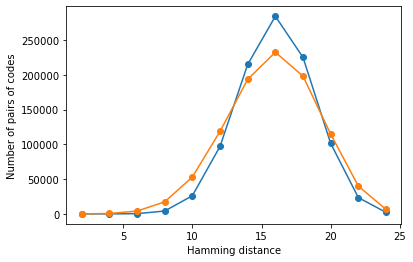

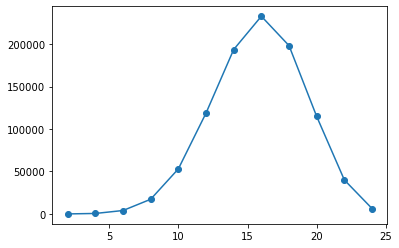

In [42]:

from scipy.spatial.distance import pdist,cdist
dists_bits = pdist(M,metric='hamming')*M.shape[-1]
nbits,cts = np.unique(dists_bits,return_counts=True)
plt.plot(nbits,cts,'o-')

In [10]:
dec.XH.shape
zc,xc,yc ,bk,a,habs,correlation with PSF,h - brightness, color: 0-750, 1-647, bit

(2500148, 10)

In [15]:
dec.XH

array([[ 1.37663958e+00,  9.22581802e+01,  1.34526375e+03, ...,
         1.49939453e+02,  0.00000000e+00, -1.00000000e+00],
       [ 1.41169131e+00,  9.42972973e+01,  1.35129914e+03, ...,
         5.27304688e+01,  0.00000000e+00, -1.00000000e+00],
       [ 5.59608744e-01,  1.11287564e+02,  1.07097868e+03, ...,
         5.03627930e+01,  0.00000000e+00, -1.00000000e+00],
       ...,
       [ 7.26105419e+01,  1.99003336e+03,  6.05099061e+02, ...,
         5.37629395e+01,  1.00000000e+00,  3.40000000e+01],
       [ 7.28895017e+01,  1.99291632e+03,  1.83303811e+03, ...,
         5.67423096e+01,  1.00000000e+00,  3.40000000e+01],
       [ 7.29865126e+01,  1.99386290e+03,  9.18988709e+02, ...,
         5.41710205e+01,  1.00000000e+00,  3.40000000e+01]])

In [13]:
np.unique(dec.XH[:,-1])

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
       25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.])

In [12]:
len('''zc,xc,yc,bk,a,habs,hn,h'''.split(','))

8

In [14]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 1499-8C83

 Directory of C:\Users\Scope2\Scope2Scripts\Zane_Ying_Virus

03/30/2023  06:30 PM    <DIR>          .
03/30/2023  06:30 PM    <DIR>          ..
03/27/2023  04:02 PM    <DIR>          .ipynb_checkpoints
03/30/2023  04:48 PM            19,004 First_Exploration_of_data.ipynb
03/30/2023  06:30 PM            37,721 FitAndDriftCorrectData.ipynb
03/30/2023  06:19 PM            82,074 GFP2Color_ChromatiAberration.ipynb
03/30/2023  06:15 PM            90,137 ioMicro.py
03/30/2023  06:25 PM    <DIR>          __pycache__
               4 File(s)        228,936 bytes
               4 Dir(s)  17,665,586,028,544 bytes free


In [30]:
dec = decoder_simple()

In [32]:
m_mat = np.load(dec.chromatic_fl)

array([[ 9.41184748e-01, -3.10163088e-05,  7.84166315e-06,
         0.00000000e+00],
       [ 1.44952186e+00, -1.49976842e-04,  9.17708808e-04,
         0.00000000e+00],
       [-1.56259698e+00,  1.28744781e-03, -1.09815209e-06,
         0.00000000e+00]])

In [25]:
vals = ['Alexa750','Cy5']
bit_dic = {(ibit//2+1,icol):ibit for ibit,icol in enumerate([vals.index(e) for e in lst])}

In [27]:
print(bit_dic)

{(1, 1): 0, (1, 0): 1, (2, 0): 2, (2, 1): 3, (3, 1): 4, (3, 0): 5, (4, 1): 6, (4, 0): 7, (5, 0): 8, (5, 1): 9, (6, 1): 10, (6, 0): 11, (7, 1): 12, (7, 0): 13, (8, 0): 14, (8, 1): 15, (9, 1): 16, (9, 0): 17, (10, 1): 18, (10, 0): 19, (11, 0): 20, (11, 1): 21, (12, 1): 22, (12, 0): 23, (13, 1): 24, (13, 0): 25, (14, 1): 26, (14, 0): 27, (15, 1): 28, (15, 0): 29, (16, 1): 30, (16, 0): 31, (17, 1): 32, (17, 0): 33, (18, 1): 34, (18, 0): 35}


In [20]:
lst = """Cy5
Alexa750
Alexa750
Cy5
Cy5
Alexa750
Cy5
Alexa750
Alexa750
Cy5
Cy5
Alexa750
Cy5
Alexa750
Alexa750
Cy5
Cy5
Alexa750
Cy5
Alexa750
Alexa750
Cy5
Cy5
Alexa750
Cy5
Alexa750
Cy5
Alexa750
Cy5
Alexa750
Cy5
Alexa750
Cy5
Alexa750
Cy5
Alexa750""".split('\n')

In [14]:
dec = decoder_simple()
pickle.load(open(dec.drift_fl,'rb'))#Conv_zscan__30--H_GFP_fits_icol0.npz


{'H_GFP': [array([  0,   5, -93]),
  [array([  0,   5, -93], dtype=int64),
   array([  0,   5, -93], dtype=int64),
   array([  0,   5, -93], dtype=int64),
   array([  0,   4, -92], dtype=int64),
   array([  0,   6, -93], dtype=int64)]],
 'H1': [array([ 0, 99, 90]),
  [array([ 0, 98, 90], dtype=int64),
   array([ 0, 99, 91], dtype=int64),
   array([ 0, 99, 90], dtype=int64),
   array([ 0, 99, 90], dtype=int64),
   array([ 0, 98, 90], dtype=int64)]],
 'H2': [array([ 0, 22, 45]),
  [array([ 0, 22, 45], dtype=int64),
   array([ 0, 23, 45], dtype=int64),
   array([ 0, 22, 45], dtype=int64),
   array([ 0, 22, 45], dtype=int64),
   array([ 0, 22, 45], dtype=int64)]],
 'H3': [array([ 0, -7, 16]),
  [array([ 0, -7, 16], dtype=int64),
   array([ 0, -6, 16], dtype=int64),
   array([ 0, -6, 16], dtype=int64),
   array([ 0, -7, 16], dtype=int64),
   array([ 0, -7, 16], dtype=int64)]],
 'H4': [array([ 0, -9, 16]),
  [array([ 0, -9, 16], dtype=int64),
   array([ 0, -9, 16], dtype=int64),
   array([ 0

In [53]:
class decoder_simple():
    def __init__(self,save_folder,fov='Conv_zscan__001'):
        self.save_folder = save_folder
        self.fov = fov
        self.decoded_fl = save_folder+os.sep+'decoded_'+fov.split('.')[0]+'--'+set_+'.npz'
        self.drift_fl = save_folder+os.sep+'drift_'+fov.split('.')[0]+'--'+set_+'.pkl'
    def check_is_complete(self):
        if os.path.exists(self.decoded_fl):
            print("Completed")
            return 1
        if not os.path.exists(self.drift_fl):
            print("Did not detect fit files")
            return -1
        print("Not completed")
        return 0
        
    def get_fovs_sets(self):
        self.drift_fls = glob.glob(self.save_folder+os.sep+'drift_*.pkl')
        self.fov_sets = [os.path.basename(fl).replace('drift_','').replace('.pkl','').split('--')
                         for fl in self.drift_fls]
    def get_XH(self,fov,set_,ncols=3):
        self.set_ = set_
        save_folder = self.save_folder
        drift_fl = save_folder+os.sep+'drift_'+fov.split('.')[0]+'--'+set_+'.pkl'
        drifts,all_flds,fov = pickle.load(open(drift_fl,'rb'))
        self.drifts,self.all_flds,self.fov = drifts,all_flds,fov

        XH = []
        for iH in tqdm(np.arange(len(all_flds))):
            fld = all_flds[iH]
            if 'MER' in os.path.basename(fld):
                for icol in range(ncols):
                    tag = os.path.basename(fld)
                    save_fl = save_folder+os.sep+fov.split('.')[0]+'--'+tag+'--col'+str(icol)+'__Xhfits.npy.npz'
                    if not os.path.exists(save_fl):save_fl = save_fl.replace('.npy','')
                    Xh = np.load(save_fl)['Xh']
                    tzxy = drifts[iH][0]
                    Xh[:,:3]+=tzxy# drift correction
                    ih = get_iH(fld) # get bit
                    bit = (ih-1)*3+icol
                    icolR = np.array([[icol,bit]]*len(Xh))
                    XH_ = np.concatenate([Xh,icolR],axis=-1)
                    XH.extend(XH_)
        self.XH = np.array(XH)
    def get_inters(self,dinstance_th=2,enforce_color=False):
        """Get an initial intersection of points and save in self.res"""
        res =[]
        if enforce_color:
            icols = self.XH[:,-2]
            XH = self.XH
            for icol in tqdm(np.unique(icols)):
                inds = np.where(icols==icol)[0]
                Xs = XH[inds,:3]
                Ts = cKDTree(Xs)
                res_ = Ts.query_ball_tree(Ts,dinstance_th)
                res += [inds[r] for r in res_]
        else:
            XH = self.XH
            Xs = XH[:,:3]
            Ts = cKDTree(Xs)
            res = Ts.query_ball_tree(Ts,dinstance_th)
        self.res = res
        
    def load_library(self,lib_fl = r'Z:\DCBBL1_3_2_2023\MERFISH_Analysis\codebook_0_New_DCBB-300_MERFISH_encoding_2_21_2023.csv',nblanks=-1):
        code_txt = np.array([ln.replace('\n','').split(',') for ln in open(lib_fl,'r') if ',' in ln])
        gns = code_txt[1:,0]
        code_01 = code_txt[1:,2:].astype(int)
        codes = np.array([np.where(cd)[0] for cd in code_01])
        codes_ = [list(np.sort(cd)) for cd in codes]
        nbits = np.max(codes)+1

        codes__ = codes_
        gns__ = list(gns)
        if nblanks>=0:
            ### get extrablanks
            from itertools import combinations
            X_codes = np.array((list(combinations(range(nbits),4))))
            X_code_01 = []
            for cd in X_codes:
                l_ = np.zeros(nbits)
                l_[cd] = 1
                X_code_01.append(l_)
            X_code_01 = np.array(X_code_01,dtype=int)
            from scipy.spatial.distance import cdist
            eblanks = np.where(np.min(cdist(code_01,X_code_01,metric='hamming'),0)>=4/float(nbits))[0]
            codes__ = codes_ + [list(e)for e in X_codes[eblanks]]
            gns__ = list(gns)+ ['blanke'+str(ign+1).zfill(4) for ign in range(len(eblanks))]
        
        bad_gns = np.array(['blank' in e for e in gns__])
        good_gns = np.where(~bad_gns)[0]
        bad_gns = np.where(bad_gns)[0]

        
        
        self.lib_fl = lib_fl ### name of coding library
        self.nbits = nbits ### number of bits
        self.gns_names = gns__  ### names of genes and blank codes
        self.bad_gns = bad_gns ### indices of the blank codes
        self.good_gns = good_gns ### indices of the good gene codes
        self.codes__ = codes__ ### final extended codes of form [bit1,bit2,bit3,bit4]
        self.codes_01 = code_01
        if nblanks>=0:
            self.codes_01 = np.concatenate([code_01,X_code_01[eblanks]],axis=0) ### final extended codes of form [0,1,0,0,1...]
        
        dic_bit_to_code = {}
        for icd,cd in enumerate(self.codes__): 
            for bit in cd:
                if bit not in dic_bit_to_code: dic_bit_to_code[bit]=[]
                dic_bit_to_code[bit].append(icd)
        self.dic_bit_to_code = dic_bit_to_code  ### a dictinary in which each bit is mapped to the inde of a code
    def get_icodes(self,nmin_bits=4,method = 'top4',redo=False,norm_brightness=None):    
        #### unfold res which is a list of list with clusters of loc.
        
        
        res = self.res

        import time
        start = time.time()
        res = [r for r in res if len(r)>=nmin_bits]
        #rlens = [len(r) for r in res]
        #edges = np.cumsum([0]+rlens)
        res_unfolder = np.array([r_ for r in res for r_ in r])
        #res0 = np.array([r[0] for r in res for r_ in r])
        ires = np.array([ir for ir,r in enumerate(res) for r_ in r])
        print("Unfolded molecules:",time.time()-start)

        ### get scores across bits
        import time
        start = time.time()
        RS = self.XH[:,-1].astype(int)
        brighness = self.XH[:,-3]
        brighness_n = brighness.copy()
        if norm_brightness is not None:
            colors = self.XH[:,norm_brightness]#self.XH[:,-1] for bits
            med_cols = {col: np.median(brighness[col==colors])for col in np.unique(colors)}
            for col in np.unique(colors):
                brighness_n[col==colors]=brighness[col==colors]/med_cols[col]
        scores = brighness_n[res_unfolder]
       
        bits_unfold = RS[res_unfolder]
        nbits = len(np.unique(RS))
        scores_bits = np.zeros([len(res),nbits])
        arg_scores = np.argsort(scores)
        scores_bits[ires[arg_scores],bits_unfold[arg_scores]]=scores[arg_scores]

        import time
        start = time.time()
        ### There are multiple avenues here: 
        #### nearest neighbors - slowest
        #### best dot product - reasonable and can return missing elements - medium speed
        #### find top 4 bits and call that a code - simplest and fastest


        if method == 'top4':
            codes = self.codes__
            vals = np.argsort(scores_bits,axis=-1)
            bcodes = np.sort(vals[:,-4:],axis=-1)
            base = [nbits**3,nbits**2,nbits**1,nbits**0]
            bcodes_b = np.sum(bcodes*base,axis=1)
            codes_b = np.sum(np.sort(codes,axis=-1)*base,axis=1)
            icodesN = np.zeros(len(bcodes_b),dtype=int)-1
            for icd,cd in enumerate(codes_b):
                icodesN[bcodes_b==cd]=icd
            bad = np.sum(scores_bits>0,axis=-1)<4
            icodesN[bad]=-1
            igood = np.where(icodesN>-1)[0]
            inds_spotsN =  np.zeros([len(res),nbits],dtype=int)-1
            inds_spotsN[ires[arg_scores],bits_unfold[arg_scores]]=res_unfolder[arg_scores]
            res_prunedN = np.array([inds_spotsN[imol][codes[icd]] for imol,icd in enumerate(icodesN) if icd>-1])
            scores_prunedN = np.array([scores_bits[imol][codes[icd]] for imol,icd in enumerate(icodesN) if icd>-1])
            icodesN = icodesN[igood]
        elif method == 'dot':
            icodesN = np.argmax(np.dot(scores_bits[:],self.codes_01.T),axis=-1)
            inds_spotsN =  np.zeros([len(res),nbits],dtype=int)-1
            inds_spotsN[ires[arg_scores],bits_unfold[arg_scores]]=res_unfolder[arg_scores]
            res_prunedN = np.array([inds_spotsN[imol][codes[icd]] for imol,icd in enumerate(icodesN) if icd>-1])
            scores_prunedN = np.array([scores_bits[imol][codes[icd]] for imol,icd in enumerate(icodesN) if icd>-1])

        print("Computed the decoding:",time.time()-start)

        import time
        start = time.time()

        mean_scores = np.mean(scores_prunedN,axis=-1)
        ordered_mols = np.argsort(mean_scores)[::-1]
        keep_mols = []
        visited = np.zeros(len(self.XH))
        for imol in tqdm(ordered_mols):
            r = np.array(res_prunedN[imol])
            r_ = r[r>=0]
            if np.all(visited[r_]==0):
                keep_mols.append(imol)
                visited[r_]=1
        keep_mols = np.array(keep_mols)
        self.scores_prunedN = scores_prunedN[keep_mols]
        self.res_prunedN = res_prunedN[keep_mols]
        self.icodesN = icodesN[keep_mols]
        print("Computed best unique assigment:",time.time()-start)
        
        XH_pruned = self.XH[self.res_prunedN]
        np.savez_compressed(self.decoded_fl,XH_pruned=XH_pruned,icodesN=self.icodesN,gns_names = np.array(self.gns_names))
        #XH_pruned -> 10000000 X 4 X 10 [z,x,y,bk...,corpsf,h,col,bit] 
        #icodesN -> 10000000 index of the decoded molecules in gns_names
        #gns_names
    def load_decoded(self):
        import time
        start= time.time()
        self.decoded_fl = self.save_folder+os.sep+'decoded_'+self.fov.split('.')[0]+'--'+self.set_+'.npz'
        self.XH_pruned = np.load(self.decoded_fl)['XH_pruned']
        self.icodesN = np.load(self.decoded_fl)['icodesN']
        self.gns_names = np.load(self.decoded_fl)['gns_names']
        print("Loaded decoded:",start-time.time())

(3, 11, 11, 11)

C:\Users\Scope2\anaconda3\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Points layer 'Points' at 0x245a3ea6730>

In [38]:
#v.add_points(Xh[:,:3])



<Points layer 'Points' at 0x2450d96c250>

In [39]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 1499-8C83

 Directory of C:\Users\Scope2\Scope2Scripts\Zane_Ying_Virus

03/27/2023  04:35 PM    <DIR>          .
03/27/2023  04:35 PM    <DIR>          ..
03/27/2023  04:02 PM    <DIR>          .ipynb_checkpoints
03/22/2023  06:14 PM            19,003 First_Exploration_of_data.ipynb
03/27/2023  04:35 PM             8,748 FitAndDriftCorrectData.ipynb
03/27/2023  03:55 PM            79,344 GFP2Color_ChromatiAberration.ipynb
03/22/2023  05:29 PM            88,169 ioMicro.py
03/22/2023  05:30 PM    <DIR>          __pycache__
               4 File(s)        195,264 bytes
               4 Dir(s)  17,668,148,068,352 bytes free


S:\ZaneTrit_3_3_2023_analysis\Conv_zscan__30_drift.pkl


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [03:51<00:00, 12.17s/it]


In [20]:
dic_drift = pickle.load(open(save_file,'rb'))

In [21]:
dic_drift

{'H_GFP': [array([  0,   5, -93]),
  [array([  0,   5, -93], dtype=int64),
   array([  0,   5, -93], dtype=int64),
   array([  0,   5, -93], dtype=int64),
   array([  0,   4, -92], dtype=int64),
   array([  0,   6, -93], dtype=int64)]],
 'H1': [array([ 0, 99, 90]),
  [array([ 0, 98, 90], dtype=int64),
   array([ 0, 99, 91], dtype=int64),
   array([ 0, 99, 90], dtype=int64),
   array([ 0, 99, 90], dtype=int64),
   array([ 0, 98, 90], dtype=int64)]],
 'H2': [array([ 0, 22, 45]),
  [array([ 0, 22, 45], dtype=int64),
   array([ 0, 23, 45], dtype=int64),
   array([ 0, 22, 45], dtype=int64),
   array([ 0, 22, 45], dtype=int64),
   array([ 0, 22, 45], dtype=int64)]],
 'H3': [array([ 0, -7, 16]),
  [array([ 0, -7, 16], dtype=int64),
   array([ 0, -6, 16], dtype=int64),
   array([ 0, -6, 16], dtype=int64),
   array([ 0, -7, 16], dtype=int64),
   array([ 0, -7, 16], dtype=int64)]]}